In [ ]:
import streamlit as st
import pandas as pd
import streamlit as st
import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
import datetime


try:
    client_id = st.secrets["client_id"]
    client_secret = st.secrets["client_secret"]
    token_url = st.secrets["token_url"]

    payload = {'grant_type': 'client_credentials'}
    response = requests.post(
        token_url,
        data=payload,
        auth=HTTPBasicAuth(client_id, client_secret)
    )
    response.raise_for_status()
    access_token = response.json().get("access_token")

except requests.RequestException as e:
    
    raise Exception(f"Failed to obtain access token: {e}")

In [9]:
try:
    stations_url = st.secrets["stations_url"]
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Accept': 'application/json'
    }
    response = requests.get(stations_url, headers=headers)
    response.raise_for_status()
    stations_data = response.json()
except requests.RequestException as e:
    raise Exception(f"Failed to retrieve weather station data: {e}")

In [ ]:
def process_station_data(stations_data):
    """
    Processes raw weather station data into a structured Pandas DataFrame.
    Args:
        stations_data (list): Raw data from the weather station API.
    Returns:
        pd.DataFrame: Processed data in tabular format.
    """
    stations_list = []
    for station in stations_data:
        position = station.get('position', {}) or {}
        coordinates = position.get('geo', {}).get('coordinates', ['N/A', 'N/A'])
        altitude = position.get('altitude', 'N/A')
        dates = station.get('dates', {}) or {}
        meta = station.get('meta', {}) or {}
        networking = station.get('networking', {}) or {}
        info = station.get('info', {}) or {}
        name = station.get('name', {}) or {}

        station_info = {
            'Station ID (original)': name.get('original', 'N/A'),
            'Custom Name': name.get('custom', 'N/A'),
            'Device Name': info.get('device_name', 'N/A'),
            'UID': info.get('uid', 'N/A'),
            'Firmware Version': info.get('firmware', 'N/A'),
            'Hardware Version': info.get('hardware', 'N/A'),
            'Rights (rw)': station.get('rights', 'N/A'),
            'Starred': station.get('starred', 'N/A'),
            'Programmed Date': info.get('programmed', 'N/A'),
            'Created Date': dates.get('created_at', 'N/A'),
            'Country': position.get('country', 'N/A'),
            'Coordinates (Latitude, Longitude)': f"({coordinates[1]}, {coordinates[0]})",
            'Altitude (m)': altitude,
            'Air Temperature (°C)': meta.get('airTemp', 'N/A'),
            'Relative Humidity (%)': meta.get('rh', 'N/A'),
            'Soil Temperature (°C)': meta.get('soilTemp', 'N/A'),
            'Solar Radiation (W/m²)': meta.get('solarRadiation', 'N/A'),
            'Rain Last (mm)': meta.get('rain_last', 'N/A'),
            'Wind Speed (m/s)': meta.get('windSpeed', 'N/A'),
            'Volumetric Water Content (Average) (%)': meta.get('volumetricAverage', 'N/A'),
            'Battery Voltage (mV)': meta.get('battery', 'N/A'),
            'Solar Panel Voltage (mV)': meta.get('solarPanel', 'N/A'),
            'Networking Type': networking.get('type', 'N/A'),
            'Roaming Status': networking.get('roaming', 'N/A'),
            'Last Communication Date': dates.get('last_communication', 'N/A'),
        }
        stations_list.append(station_info)

    return pd.DataFrame(stations_list)


stations_df = process_station_data(stations_data)

stations_df["Custom Name"]

In [ ]:
stations_df

In [ ]:
# /data/{{STATION-ID}}/{{DATA-GROUP}}/from/{{FROM-UNIX-TIMESTAMP}}/to/{{TO-UNIX-TIMESTAMP }}
data = ''
station_id = '002127FE'
data_group = 'daily'
time_period = '12m'  # Retrieve the last full month


import time
import datetime

# Start and end date
start_date = datetime.datetime(2024, 11, 15, 0, 0)
end_date = datetime.datetime(2024, 11, 30, 23, 59, 59)

# Convert to Unix timestamps
start_timestamp = int(time.mktime(start_date.timetuple()))
end_timestamp = int(time.mktime(end_date.timetuple()))


# API URL to fetch data
# data_url = f"https://api.fieldclimate.com/v2/data/{station_id}/{data_group}/last/{time_period}"

data_url = f"https://api.fieldclimate.com/v2/data/{station_id}/{data_group}/from/{start_timestamp}/to/{end_timestamp}"


# Set headers with the access token
headers = {
    'Authorization': f'Bearer {access_token}',
    'Accept': 'application/json'
}

# Make the GET request
response = requests.get(data_url, headers=headers)

# Check for a successful response
if response.status_code == 200:
    data = response.json()
    print(f" Data for station {station_id} retrieved successfully.")
elif response.status_code == 404:
    print(f" Error 404: Station ID {station_id} not found. Skipping this station.")
else:
    print(f" Failed to retrieve data for station {station_id}. Status Code: {response.status_code}")
    print(f" Response: {response.text}")

data

In [17]:
import pandas as pd
import urllib.parse

# Base URL for Google Sheets public CSV export
sheet_url = st.secrets["historic_data_url"]
doc_id = sheet_url.split("/")[5]
base_url = f"https://docs.google.com/spreadsheets/d/{doc_id}/gviz/tq?tqx=out:csv&sheet="

# Extract sheet names from stations_df["Custom Name"]

#sheet_names = st.session_state["station_status"]["Custom Name"].unique()
sheet_names = stations_df["Custom Name"].unique()

# Dictionary to hold DataFrames for each sheet
dataframes = {}

# Sanitize sheet names and fetch data
for sheet in sheet_names:
    try:
        # Sanitize sheet name for URL
        sanitized_sheet = urllib.parse.quote(sheet.strip())
        url = base_url + sanitized_sheet
        df = pd.read_csv(url)
        dataframes[sheet] = df
    except Exception as e:
        print(f"Error loading sheet: {sheet}, {e}")


In [20]:
dataframes["Azaz"]

,Station ID,Custom Name,Date/Time,Solar radiation (avg),Solar Panel (last),Precipitation (sum),Battery (last),Leaf Wetness (time),HC Serial Number (last),HC Air temperature (avg),...,PI-Profile Soil Moisture 6 (avg),PI-Profile Soil Temperature 1 (avg),PI-Profile Soil Temperature 2 (avg),PI-Profile Soil Temperature 3 (avg),PI-Profile Soil Temperature 4 (avg),PI-Profile Soil Temperature 5 (avg),PI-Profile Skin Temperature (avg),ET0 (result),Wind orientation (result),Midnight (result)
0,213513,Azaz,2024-07-04 00:00:00,116,0,0,6280,0,20734972,30.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,1720051200
1,213513,Azaz,2024-07-05 00:00:00,7,6499,0,6300,0,20734972,28.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0,1720137600
2,213513,Azaz,2024-07-30 00:00:00,120,0,4,6303,0,20734972,30.02,...,3.89,32.49,32.97,34.14,33.65,33.09,33.65,NaN,NaN,1722297600
3,213513,Azaz,2024-07-31 00:00:00,3,0,0,6277,180,20734972,30.16,...,3.55,30.58,30.61,30.44,30.13,30.30,30.13,NaN,60.0,1722384000


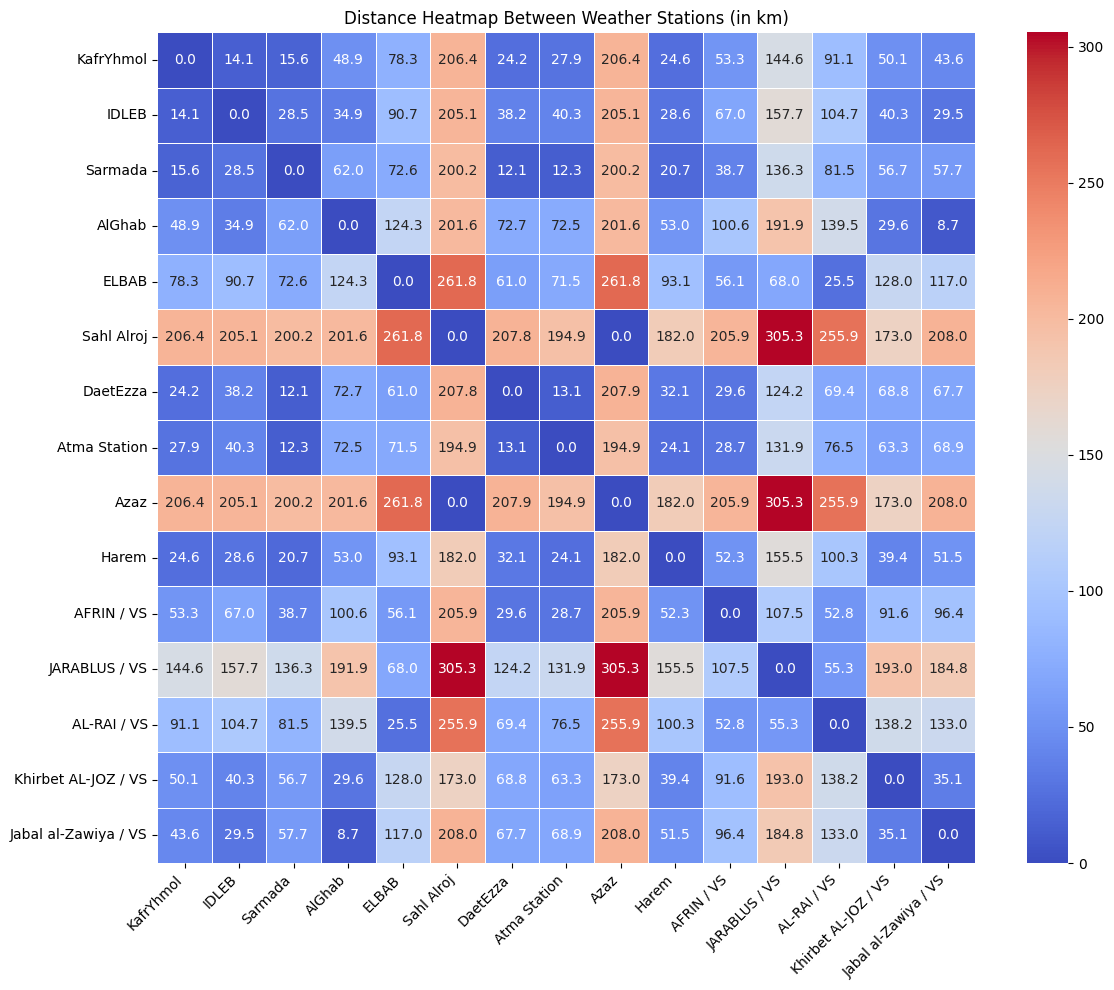

,KafrYhmol,IDLEB,Sarmada,AlGhab,ELBAB,Sahl Alroj,DaetEzza,Atma Station,Azaz,Harem,AFRIN / VS,JARABLUS / VS,AL-RAI / VS,Khirbet AL-JOZ / VS,Jabal al-Zawiya / VS
KafrYhmol,0.000000,14.103269,15.606671,48.911605,78.296678,206.380369,24.178709,27.884884,206.385433,24.640733,53.307074,144.636687,91.078919,50.066619,43.580558
IDLEB,14.103269,0.000000,28.530437,34.894925,90.705586,205.120903,38.216682,40.262492,205.125451,28.558128,67.028804,157.739054,104.722420,40.327600,29.510142
Sarmada,15.606671,28.530437,0.000000,61.985553,72.602831,200.192059,12.124660,12.312459,200.197630,20.720220,38.700567,136.325526,81.509898,56.723098,57.706162
AlGhab,48.911605,34.894925,61.985553,0.000000,124.269615,201.584404,72.717946,72.454228,201.587575,52.982050,100.610864,191.874976,139.467436,29.618774,8.724697
ELBAB,78.296678,90.705586,72.602831,124.269615,0.000000,261.793005,60.977408,71.490274,261.799668,93.081233,56.095264,67.985016,25.460268,127.950437,117.005629
Sahl Alroj,206.380369,205.120903,200.192059,201.584404,261.793005,0.000000,207.848937,194.902846,0.008948,182.002266,205.905089,305.252805,255.875678,172.994290,208.040901
DaetEzza,24.178709,38.216682,12.124660,72.717946,60.977408,207.848937,0.000000,13.107966,207.854824,32.119598,29.563292,124.204853,69.401710,68.842964,67.726474
Atma Station,27.884884,40.262492,12.312459,72.454228,71.490274,194.902846,13.107966,0.000000,194.908802,24.123925,28.718087,131.854155,76.529286,63.254504,68.874816
Azaz,206.385433,205.125451,200.197630,201.587575,261.799668,0.008948,207.854824,194.908802,0.000000,182.007465,205.911875,305.260455,255.882882,172.997805,208.044311
Harem,24.640733,28.558128,20.720220,52.982050,93.081233,182.002266,32.119598,24.123925,182.007465,0.000000,52.286341,155.532997,100.309669,39.350255,51.539012


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

# Stations and coordinates
stations = {
    "KafrYhmol": (36.04974, 36.70756),
    "IDLEB": (35.940536, 36.627528),
    "Sarmada": (36.190332, 36.702592),
    "AlGhab": (35.693416, 36.3887),
    "ELBAB": (36.38358, 37.474712),
    "Sahl Alroj": (36.77938, 34.590896),
    "DaetEzza": (36.248968, 36.81638),
    "Atma Station": (36.300376, 36.685032),
    "Azaz": (36.779336, 34.590812),
    "Harem": (36.165816, 36.47426),
    "AFRIN / VS": (36.5119, 36.8695),
    "JARABLUS / VS": (36.8175, 38.0111),
    "AL-RAI / VS": (36.6119, 37.4467),
    "Khirbet AL-JOZ / VS": (35.9014, 36.1833),
    "Jabal al-Zawiya / VS": (35.7014, 36.4846),
}

# Calculate pairwise distances and store in a grid (dataframe)
station_names = list(stations.keys())
distance_matrix = np.zeros((len(station_names), len(station_names)))

for i, station1 in enumerate(station_names):
    for j, station2 in enumerate(station_names):
        if i != j:
            coord1 = stations[station1]
            coord2 = stations[station2]
            distance_matrix[i][j] = geodesic(coord1, coord2).kilometers
        else:
            distance_matrix[i][j] = 0  # Distance to itself is 0

# Convert to DataFrame for easier handling
distance_df = pd.DataFrame(distance_matrix, index=station_names, columns=station_names)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Distance Heatmap Between Weather Stations (in km)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Return the distance DataFrame for clarity
distance_df
